# **DISTIL Installation**

In [ ]:
!git clone https://github.com/decile-team/distil.git
!pip install apricot-select
%cd distil/examples/

Cloning into 'distil'...
remote: Enumerating objects: 2126, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 2126 (delta 8), reused 0 (delta 0), pack-reused 2080
Receiving objects: 100% (2126/2126), 14.94 MiB | 27.56 MiB/s, done.
Resolving deltas: 100% (1311/1311), done.
     |████████████████████████████████| 163kB 4.5MB/s 
  Created wheel for apricot-select: filename=apricot_select-0.6.1-cp37-none-any.whl size=48789 sha256=1fa4bae0e6b2d24f04ae8170e342c86955392e208f1d836360dc7a4c24d9cfc5
  Stored in directory: /root/.cache/pip/wheels/27/53/c1/67fd7b8bd5be9d506fdac6bb9b73b5c69734da8210833998fa
Successfully built apricot-select
/content/distil/examples


**Imports**

In [ ]:
import pandas as pd 
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import torch
import torch.optim as optim
from torch.autograd import Variable
import sys
import os
from google.colab import drive
sys.path.append('../')
from distil.active_learning_strategies import GLISTER, BADGE, EntropySampling, RandomSampling

from distil.utils.models.resnet import ResNet18
from distil.utils.data_handler import DataHandler_CIFAR10
from distil.utils.dataset import get_dataset
from distil.utils.train_helper import data_train

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


# **Data, Model & Directory Configuration**

The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. The training set contains 50,000 images and test set contains 10,000 images. We will use DISTIL's custom data handler for CIFAR10:- DataHandler_CIFAR10 to load the labeled as well as unlabeled data.

In [ ]:
data_set_name = 'CIFAR10'
download_path = '../downloaded_data/'
X, y, X_test, y_test = get_dataset(data_set_name, download_path)
dim = np.shape(X)[1:]
handler = DataHandler_CIFAR10

X_tr = X[:1000]
y_tr = y[:1000]
X_unlabeled = X[1000:]
y_unlabeled = y[1000:]

X_test = X_test
y_test = y_test.numpy()

nclasses = 10
n_rounds = 9    ##Number of rounds to run active learning
budget = 3000 

net = ResNet18()


Extracting ../downloaded_data//CIFAR10/cifar-10-python.tar.gz to ../downloaded_data//CIFAR10
Files already downloaded and verified


In [ ]:
#Mount Storage
colab_model_storage_mount = "/content/drive"
drive.mount(colab_model_storage_mount)

#Model Directory
base_dir = "/content/drive/MyDrive/distil_experiments/cifar10/"
os.makedirs(base_dir, exist_ok = True)
model_directory = os.path.join(base_dir, 'base_model.pth')

Mounted at /content/drive


# **INITIAL MODEL TRAINING**
Run only if you don't have a base model or when you are running it for the first time. Otherwise, you skip this cell and load model by running the below cell

In [ ]:
args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd'} 
dt = data_train(X_tr, y_tr, net, handler, args)
clf = dt.train()
torch.save(clf.state_dict(), model_directory)

Training..
Epoch: 110 Training accuracy: 0.993


# **LOAD BASE MODEL**

In [ ]:
base_dir = "/content/drive/MyDrive/distil_experiments/cifar10/"
model_directory = os.path.join(base_dir, 'base_model.pth')
net.load_state_dict(torch.load(model_directory))
clf = net

# **RANDOM SAMPLING**
This strategy is often used as a baseline, where we pick a set of unlabled points randomly. Here we create a instance of distil.active_learning_strategies.random_sampling.RandomSampling by passing following parameters:

**X (Numpy array)** – Features of the labled set of points

**Y (Numpy array)** – Lables of the labled set of points

**unlabeled_x (Numpy array)** – Features of the unlabled set of points

**net (class object)** – Model architecture used for training. Could be instance of models defined in distil.utils.models or something similar.

**handler (class object)** – It should be a subclass of torch.utils.data.Dataset i.e, have __getitem__ and __len__ methods implemented, so that is could be passed to pytorch DataLoader.Could be instance of handlers defined in distil.utils.DataHandler or something similar.

**nclasses (int)** – No. of classes in tha dataset

**args (dictionary)**– This dictionary should have ‘batch_size’ as a key. 'batch_size' should be such that one can exploit the benefits of tensorization while honouring the resourse constraits. This ‘batch_size’ therefore can be different than the one used for training.

We initally pass None for X,Y and unlabeled_x. Later we update using update functions of training class and RandomSampling class. 


In [ ]:
#Initializing Strategy Class
strategy_args = {'batch_size' : 1000}
strategy = RandomSampling(X_tr, y_tr, X_unlabeled, net, handler, nclasses, strategy_args)

#Initial Training
args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd'} 
dt = data_train(X_tr, y_tr, clf, handler, args)

#Updating the trained model in strategy class
strategy.update_model(clf)

# y_pred = strategy.predict(X_test).numpy()
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(X_test, y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    #Using select function for getting next set of data points
    idx = strategy.select(budget)

    #Saving state of model, since labeling new points might take time
    strategy.save_state('./state.pkl')

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state('./state.pkl')
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    acc[rd] = dt.get_acc_on_set(X_test, y_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'random.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 56.49
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 4000
Training..
Epoch: 112 Training accuracy: 0.992
Testing accuracy: 77.09
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 7000
Training..
Epoch: 137 Training accuracy: 0.99
Testing accuracy: 81.44
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 10000
Training..
Epoch: 162 Training accuracy: 0.991
Testing accuracy: 85.57
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 13000
Training..
Epoch: 179 Training accuracy: 0.992
Testing accuracy: 87.38
-------------------------------------------------
Round 5
-------------------------------------------------
Number of t

# **Uncertanity based Active learning Strategy**

The most basic active learning strategy, where we select samples about which the model is most uncertain. To quantify the uncertainity we use entropy, therefore select points which have maximum entropy. Let $z_i$ be output from the model then the correponding softmax would be $$\sigma(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}$$. Then entropy can be calculated as, $$ENTROPY = -\sum_j \sigma(z_j)*log(\sigma(z_i))$$

Here we create a instance of distil.active_learning_strategies.entropy_sampling.EntropySampling with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling.

**Reloading Base Model & Data**

In [ ]:
data_set_name = 'CIFAR10'
download_path = '../downloaded_data/'
X, y, X_test, y_test = get_dataset(data_set_name, download_path)
dim = np.shape(X)[1:]
handler = DataHandler_CIFAR10

X_tr = X[:1000]
y_tr = y[:1000]
X_unlabeled = X[1000:]
y_unlabeled = y[1000:]

X_test = X_test
y_test = y_test.numpy()

nclasses = 10
n_rounds = 9    ##Number of rounds to run active learning
budget = 3000 

net = ResNet18()

base_dir = "/content/drive/MyDrive/distil_experiments/cifar10/"
model_directory = os.path.join(base_dir, 'base_model.pth')
net.load_state_dict(torch.load(model_directory))
clf = net


Extracting ../downloaded_data//CIFAR10/cifar-10-python.tar.gz to ../downloaded_data//CIFAR10
Files already downloaded and verified


In [ ]:
#Initializing Strategy Class
strategy_args = {'batch_size' : 1000}
strategy = EntropySampling(X_tr, y_tr, X_unlabeled, clf, handler, nclasses, strategy_args)

#Initial Training
args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd'}
dt = data_train(X_tr, y_tr, clf, handler, args)

#Updating the trained model in strategy class
strategy.update_model(clf)

acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(X_test, y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    #Using select function for getting next set of data points
    idx = strategy.select(budget)

    #Saving state of model, since labeling new points might take time
    strategy.save_state('./state.pkl')

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state('./state.pkl')
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    acc[rd] = dt.get_acc_on_set(X_test, y_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'entropy.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 56.49
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 4000
Training..
Epoch: 123 Training accuracy: 0.991
Testing accuracy: 78.79
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 7000
Training..
Epoch: 163 Training accuracy: 0.991
Testing accuracy: 85.0
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 10000
Training..
Epoch: 180 Training accuracy: 0.99
Testing accuracy: 88.72
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 13000
Training..
Epoch: 198 Training accuracy: 0.992
Testing accuracy: 90.82
-------------------------------------------------
Round 5
-------------------------------------------------
Number of tr

# **BADGE**
This method is based on the paper [Deep Batch Active Learning by Diverse, Uncertain Gradient Lower Bounds](https://arxiv.org/abs/1906.03671). Here at each around of selection loss gradients are computed using the hypothesised lables. Then to points to be labled are selected by applying k-means++ on these loss gradients. 

Here we create a instance of distil.active_learning_strategies.badge.BADGE with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling.

**Reloading Base Model & Data**

In [ ]:
data_set_name = 'CIFAR10'
download_path = '../downloaded_data/'
X, y, X_test, y_test = get_dataset(data_set_name, download_path)
dim = np.shape(X)[1:]
handler = DataHandler_CIFAR10

X_tr = X[:1000]
y_tr = y[:1000]
X_unlabeled = X[1000:]
y_unlabeled = y[1000:]

X_test = X_test
y_test = y_test.numpy()

nclasses = 10
n_rounds = 9    ##Number of rounds to run active learning
budget = 3000 

net = ResNet18()

base_dir = "/content/drive/MyDrive/distil_experiments/cifar10/"
model_directory = os.path.join(base_dir, 'base_model.pth')
net.load_state_dict(torch.load(model_directory))
clf = net

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
strategy_args = {'batch_size' : 1000}
strategy = BADGE(X_tr, y_tr, X_unlabeled, clf, handler, nclasses, strategy_args)

args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd'}
dt = data_train(X_tr, y_tr, clf, handler, args)

strategy.update_model(clf)

acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(X_test, y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')
    idx = strategy.select(budget)
    strategy.save_state('./state.pkl')

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state('./state.pkl')
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)

    acc[rd] = dt.get_acc_on_set(X_test, y_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break
        
print('Training Completed')
with open(os.path.join(base_dir,'badge.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 56.49
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 4000
Training..
Epoch: 114 Training accuracy: 0.991
Testing accuracy: 78.71
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 7000
Training..
Epoch: 157 Training accuracy: 0.991
Testing accuracy: 85.15
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 10000
Training..
Epoch: 184 Training accuracy: 0.993
Testing accuracy: 88.43
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 13000
Training..
Epoch: 190 Training accuracy: 0.99
Testing accuracy: 90.51
-------------------------------------------------
Round 5
-------------------------------------------------
Number of t

# **GLISTER**
This is implemetation of GLISTER-ACTIVE from the paper [GLISTER: Generalization based Data Subset Selection for Efficient and Robust Learning](https://arxiv.org/abs/2012.10630). GLISTER methods tries to solve a bi-level optimisation problem.
\begin{equation*}
\overbrace{\underset{{S \subseteq {\mathcal U}, |S| \leq k}}{\operatorname{argmax\hspace{0.7mm}}} LL_V(\underbrace{\underset{\theta}{\operatorname{argmax\hspace{0.7mm}}} LL_T( \theta, S)}_{inner-level}, {\mathcal V})}^{outer-level}
\end{equation*}
where is $S$ is set of points selected at each round,${\mathcal V}$ could be a dedicated validation set with labled points or could be union of labeled and unlabeled points with hypothesised labels, $k$ is the budget.
To set ${\mathcal V}$ to be validation set, while calling **GLISTER** class in the toolkit set _valid=TRUE_ and pass validation set otherwise set _valid=False_.

Solving this problem directly is almost impossible, therefore we resort to one-step approxiations.We start we $S^0$ as empty set and bulid it as $S^k = S^{k-1} \cup e$, where $e$ is $\underset{e}{\operatorname{argmax\hspace{0.7mm}}} G_{\theta}(e | S^k)$. We define,$$G_{\theta}(e | S^k) = LL_{V}(\theta^{k}, {\mathcal V})$$ and update $$\theta^k \leftarrow \theta^{k-1} -  \eta \nabla_{\theta} LL_T(\hat{\theta}, e)$$ where $\hat{\theta}$ is the parameters of the model at the begining of the selection.
To prevent overfitting, we can add regularizer to GLISTER, which can be set by **_typeOf_**. **_typeOf_** can be set to - **'none'**(which is default) for normal GLISTER,**'Rand'** for replacing **_lam_** fraction of points replaced by random points, **'Diversity'** adding diversity set function while computing gain and **'FacLoc'** adding Facility Location set function while computing gain. **_lam_** for both **'Diversity'** and **'FacLoc'** determines the weightage given to them while computing the gain.

Here we create a instance of distil.active_learning_strategies.glister.GLISTER( with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling, we slight change that, **args** dictionary should have keys ‘batch_size’ and ‘lr’. ‘lr’ should be the learning rate used for training. In addition to those folowing additional parameters may be passed:

**valid (boolean)** – Whether validation set is passed or not

**X_val (Numpy array, optional)** – Features of the points in the validation set. Mandatory if valid=True.

**Y_val (Numpy array, optional)** – Lables of the points in the validation set. Mandatory if valid=True.

**loss_criterion (class object, optional)** – The type of loss criterion. Default is torch.nn.CrossEntropyLoss()

**typeOf (str, optional)** – Determines the type of regulariser to be used. Default is ‘none’. For random regulariser use ‘Rand’. To use Facility Location set functiom as a regulariser use ‘FacLoc’. To use Diversity set functiom as a regulariser use ‘Diversity’.

**lam (float, optional)** – Determines the amount of regularisation to be applied. Mandatory if is not typeOf=’none’ and by default set to None. For random regulariser use values should be between 0 and 1 as it determines fraction of points replaced by random points. For both ‘Diversity’ and ‘FacLoc’ lam determines the weightage given to them while computing the gain.

**kernel_batch_size (int, optional)** – For 'Diversity' and 'FacLoc' regualrizer versions, similarity kernel is to be computed, which entails creating a 3d torch tensor of dimenssions $kernel\_batch\_size^{2}*(feature\ dimenssion)$. Again kernel_batch_size should be such that one can exploit the benefits of tensorization while honouring the resourse constraits.

**Reloading Base Model & Data**

In [ ]:
data_set_name = 'CIFAR10'
download_path = '../downloaded_data/'
X, y, X_test, y_test = get_dataset(data_set_name, download_path)
dim = np.shape(X)[1:]
handler = DataHandler_CIFAR10

X_tr = X[:1000]
y_tr = y[:1000]
X_unlabeled = X[1000:]
y_unlabeled = y[1000:]

X_test = X_test
y_test = y_test.numpy()

nclasses = 10
n_rounds = 9    ##Number of rounds to run active learning
budget = 3000 

net = ResNet18()

base_dir = "/content/drive/MyDrive/distil_experiments/cifar10/"
model_directory = os.path.join(base_dir, 'base_model.pth')
net.load_state_dict(torch.load(model_directory))
clf = net

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import warnings
warnings.filterwarnings("ignore")
strategy_args = {'batch_size' : 20, 'lr':float(0.01)}
strategy = GLISTER(X_tr, y_tr, X_unlabeled, clf, handler, nclasses, strategy_args,valid=False, typeOf='rand', lam=0.1)

args = {'n_epoch':300, 'lr':float(0.01), 'batch_size':20, 'max_accuracy':0.99, 'optimizer':'sgd'}
dt = data_train(X_tr, y_tr, clf, handler, args)

strategy.update_model(clf)

acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(X_test, y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')
    idx = strategy.select(budget)
    strategy.save_state('./state.pkl')

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state('./state.pkl')
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)

    acc[rd] = dt.get_acc_on_set(X_test, y_test)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break
        
print('Training Completed')
with open(os.path.join(base_dir,'glister.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 56.49
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 4000
Training..
Epoch: 106 Training accuracy: 0.991
Testing accuracy: 78.96
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 7000
Training..
Epoch: 153 Training accuracy: 0.99
Testing accuracy: 83.24
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 10000
Training..
Epoch: 176 Training accuracy: 0.991
Testing accuracy: 88.07
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 13000
Training..
Epoch: 190 Training accuracy: 0.991
Testing accuracy: 89.54
-------------------------------------------------
Round 5
-------------------------------------------------
Number of t

**VISUALISATION**

Text(0.5, 1.0, 'DISTIL_CIFAR10')

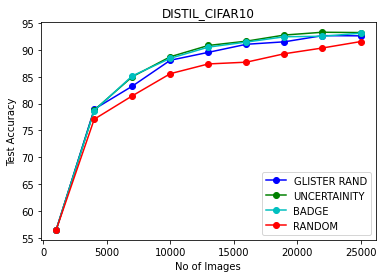

In [ ]:
#Loading accuracies
with open(os.path.join(base_dir,'entropy.txt'), 'r') as f:
  acc_ = f.readlines()
acc_en = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'badge.txt'), 'r') as f:
  acc_ = f.readlines()
acc_bd = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'glister.txt'), 'r') as f:
  acc_ = f.readlines()
acc_gl = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'random.txt'), 'r') as f:
  acc_ = f.readlines()
acc_rd = [round(float(x)*100, 2) for x in acc_]

#Plotting
import matplotlib.pyplot as plt
budget = 3000 
n_rounds = 9
x_axis = np.array([1000+budget*i for i in range(n_rounds)])
plt.figure()
plt.plot(x_axis, acc_gl, 'b-', label='GLISTER RAND',marker='o')
plt.plot(x_axis, acc_en, 'g-', label='UNCERTAINITY',marker='o')
plt.plot(x_axis, acc_bd, 'c', label='BADGE',marker='o')
plt.plot(x_axis, acc_rd, 'r', label='RANDOM',marker='o')


plt.legend()
plt.xlabel('No of Images')
plt.ylabel('Test Accuracy')
plt.title('DISTIL_CIFAR10')